# Semester 3 Coding Portfolio Topic 6 Formative Part 1/2:
# Agent-Based Modeling: The Schelling Segregation model

This notebook covers the following topics:
 - Constructing an agent-based model
 - Studying model dynamics

This notebook is expected to take around 5 hours to complete:
 - 2 hours for the formative part
 - 3 hours of self-study on the topics covered by this notebook

Like all topics in this portfolio, this topic is split into two sections:
 - Formative 
 - Summative

<b>Formative section</b><br>
Simply complete the given functions such that they pass the automated tests. This part is graded Pass/Fail; you must get 100% correct!
You can submit your notebook through Canvas as often as you like. Make sure to start doing so early to insure that your code passes all tests!
You may ask for help from fellow students and TAs on this section, and solutions might be provided later on.

This week we're going to implement and experiment with the classic Schelling model of segregation. 

Schelling, T. C. (1971). Dynamic models of segregation. Journal of mathematical sociology, 1(2), 143-186. https://www.tandfonline.com/doi/abs/10.1080/0022250X.1971.9989794 

The paper is amazing and very much worth reading. 

The Schelling segregation model is a very simple agent-based model that analyze the dynamics of segregation. The model is so general that it can even be applied to why water and oil separate.  

The model works with two types of agents distributed on a grid. Each agent is either type A or type B. The agents are happy if a certain percentage of their neighbors are of the same type; otherwise, they will try to move to another spot in the grid. 

Let's start by implementing the model.

In [1]:
# First, install all necessary packages to avoid kernel restarts
# This ensures all dependencies are available before we start coding
%pip install numpy matplotlib ipython -q

# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, animation
from IPython.display import HTML

Note: you may need to restart the kernel to use updated packages.


## Part 1. Develop base model dynamics

## Exercise 1A

In [2]:
# First, we initialize a grid, where each point in the grid is randomly set to be either populated by type A, by type B, or is empty
def initialize_grid(size, fraction_empty, fraction_A):
    """
    Initialize a grid for the Schelling segregation model.
    
    Parameters:
    -----------
    size : int
        The size of the square grid (size x size)
    fraction_empty : float
        The fraction of cells that should be empty (0.0 to 1.0)
    fraction_A : float
        Of the non-empty cells, the fraction that should be type A (0.0 to 1.0)
        The remaining non-empty cells will be type B
    
    Returns:
    --------
    grid : numpy.ndarray
        A 2D array where: 0 = empty, 1 = Type A agent, 2 = Type B agent
    empty_cells : list
        List of tuples (x, y) coordinates of all empty cells
    """
    # Initialize grid with all zeros (all cells empty initially)
    grid = np.zeros((size, size))    
    
    # We keep track of empty cells through a list for optimization reasons,
    # as we want to be able to find an empty cell in O(1) time later
    empty_cells = []            
    
    # Loop over each cell in the grid
    for x in range(size):
        for y in range(size):
            # Generate a random number between 0 and 1
            # This will help us decide probabilistically what to place in each cell
            random_value = np.random.random()
            
            # First check: is this cell empty?
            # If random_value is less than fraction_empty, make it empty
            if random_value < fraction_empty:
                # Keep it as 0 (empty) and record its location
                empty_cells.append((x, y))
            else:
                # Cell is not empty, so we need to decide: Type A or Type B?
                # We need to adjust our probability threshold because we're now in
                # the "non-empty" space. We use conditional probability here.
                # Of the non-empty space (1 - fraction_empty), what fraction should be A?
                
                # Calculate the adjusted probability for Type A
                # This ensures that fraction_A of non-empty cells are Type A
                prob_A_given_not_empty = fraction_A
                
                # Generate another random number for this decision
                random_agent = np.random.random()
                
                if random_agent < prob_A_given_not_empty:
                    # Place Type A agent (value = 1)
                    grid[x, y] = 1
                else:
                    # Place Type B agent (value = 2)
                    grid[x, y] = 2
    
    return grid, empty_cells



## Exercise 1B

In [3]:
# This returns the fraction of the neighbors of a given agent that are of the same type.
def fraction_neighbors_same(x, y, grid):
    """
    Calculate what fraction of an agent's neighbors are of the same type.
    
    Parameters:
    -----------
    x, y : int
        The coordinates of the agent in the grid
    grid : numpy.ndarray
        The 2D grid containing agents (0=empty, 1=Type A, 2=Type B)
    
    Returns:
    --------
    float or None
        Fraction of neighbors of the same type (0.0 to 1.0)
        Returns None if the cell is empty
    """
    # Get the agent type at this location
    agent = grid[x, y]
    
    # If this cell is empty, return None (empty cells don't have neighbors to check)
    if agent == 0:
        return None
    
    # Get grid dimensions for wrapping (toroidal topology)
    size_x, size_y = grid.shape
    
    # Initialize counters
    same_type_count = 0  # Count of neighbors that are the same type
    total_neighbors = 0  # Total count of non-empty neighbors
    
    # Define the 8 Moore neighbors (including diagonals)
    # These are the offsets from the current cell (x, y)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),  # Top row
        (0, -1),           (0, 1),   # Middle row (skip center cell)
        (1, -1),  (1, 0),  (1, 1)    # Bottom row
    ]
    
    # Check each neighbor
    for dx, dy in neighbor_offsets:
        # Calculate neighbor coordinates with wrapping (toroidal topology)
        # Using modulo (%) ensures that coordinates wrap around the edges
        # Example: if x=0 and dx=-1, then (0-1) % size = size-1 (wraps to right edge)
        neighbor_x = (x + dx) % size_x
        neighbor_y = (y + dy) % size_y
        
        # Get what's in the neighbor cell
        neighbor = grid[neighbor_x, neighbor_y]
        
        # Only count non-empty neighbors (skip empty cells)
        if neighbor != 0:
            total_neighbors += 1
            
            # Check if neighbor is the same type as our agent
            if neighbor == agent:
                same_type_count += 1
    
    # Avoid division by zero: if there are no non-empty neighbors, return 0
    # (This shouldn't happen in practice with typical parameters, but it's good to be safe)
    if total_neighbors == 0:
        return 0.0
    
    # Calculate and return the fraction
    fraction = same_type_count / total_neighbors
    return fraction
    
# This function checks if a specific agent is satisfied. 
# The agent is satisfied if more than a given threshold of their neighbors is of the same type as themselves.
def is_satisfied(x, y, grid, similarity_threshold):
    fraction_same = fraction_neighbors_same(x,y,grid)

    # Empty areas are always satisfied 
    if fraction_same is None:
        return True
    
    # Is fraction that are the same higher or equal to our threshold?
    return fraction_same >= similarity_threshold



## Exercise 1C

In [4]:
# This is the loop that updates the model and runs the model dynamics.
def update(grid, emptycells, size_grid, similarity_threshold, agents_per_step):
    """
    Update the grid by checking and moving unsatisfied agents.
    
    This function implements the core dynamics of the Schelling model:
    - Randomly selects agents to check
    - If an agent is not satisfied (has too few neighbors of the same type),
      it moves to a random empty cell
    - Tracks whether any moves occurred
    
    Parameters:
    -----------
    grid : numpy.ndarray
        The 2D grid containing agents (0=empty, 1=Type A, 2=Type B)
    emptycells : list
        List of tuples (x, y) coordinates of all empty cells
    size_grid : int
        The size of the grid (used for random coordinate selection)
    similarity_threshold : float
        The minimum fraction of same-type neighbors required for satisfaction (0.0 to 1.0)
    agents_per_step : int
        How many agents to check in this update step
    
    Returns:
    --------
    grid : numpy.ndarray
        The updated grid after moves
    emptycells : list
        The updated list of empty cells
    was_move : bool
        True if at least one agent moved, False otherwise
    """
    # Flag to track if any moves occurred in this update step
    was_move = False
    
    # Check multiple agents per update step
    # This allows the model to evolve faster and more smoothly
    for _ in range(agents_per_step):
        # Pick a random cell in the grid to check
        # This simulates randomly selecting an agent to evaluate
        x = np.random.randint(0, size_grid)
        y = np.random.randint(0, size_grid)
        
        # Get what's in this cell
        agent_type = grid[x, y]
        
        # Skip if this cell is empty (nothing to check)
        if agent_type == 0:
            continue
        
        # Check if this agent is satisfied with its current location
        # An agent is satisfied if the fraction of same-type neighbors
        # is greater than or equal to the similarity_threshold
        satisfied = is_satisfied(x, y, grid, similarity_threshold)
        
        # If the agent is NOT satisfied, we need to move it
        if not satisfied:
            # Before moving, we need to check if there are any empty cells available
            if len(emptycells) == 0:
                # No empty cells available, can't move
                continue
            
            # Pick a random empty cell to move to
            # This is why we keep the emptycells list - it makes finding
            # an empty cell very fast (O(1) random selection vs O(n) search)
            empty_idx = np.random.randint(0, len(emptycells))
            new_x, new_y = emptycells[empty_idx]
            
            # Move the agent to the new location
            grid[new_x, new_y] = agent_type
            
            # Clear the old location (make it empty)
            grid[x, y] = 0
            
            # Update the emptycells list:
            # 1. Remove the cell we just moved TO (it's no longer empty)
            emptycells.pop(empty_idx)
            # 2. Add the cell we moved FROM (it's now empty)
            emptycells.append((x, y))
            
            # Record that a move occurred
            was_move = True
    
    return grid, emptycells, was_move



### Make a nice animation of the dynamics of the model
Let's start by making an animation to track the changes of the model over time. 

Animations in python are unfortunately a bit clunky, so we'll provide the code here.

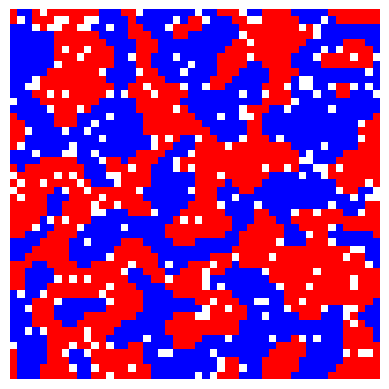

In [5]:
# Model parameters for the animation
# These control how the model behaves
size_grid = 50  # Size of the grid (50x50 cells)
fraction_empty = 0.1  # 10% of cells are empty (gives agents space to move)
fraction_A = 0.5  # 50% of agents are Type A, 50% are Type B
similarity_threshold = 0.4  # Agents want at least 40% of neighbors to be same type

# Initialize the grid with agents randomly distributed
# This creates our starting state before agents start moving
grid, emptycells = initialize_grid(size_grid, fraction_empty, fraction_A)

# Set up the visualization/plot for the animation
# We'll display the grid as an image where:
# - White cells = empty spaces
# - Red cells = Type A agents
# - Blue cells = Type B agents
fig, ax = plt.subplots()
cmap = colors.ListedColormap(['white', 'red', 'blue'])  # Color map for the three states
bounds = [0, 1, 2, 3]  # Boundaries for the color mapping
norm = colors.BoundaryNorm(bounds, cmap.N)  # Normalize values to color boundaries
img = ax.imshow(grid, cmap=cmap, norm=norm)  # Display the initial grid
ax.axis('off')  # Hide axes for a cleaner look

# This function is called for each frame of the animation
# It updates the grid state and displays it
def update_video(frame, img, grid, emptycells, size, similarity_threshold, agents_per_step):
    """
    Update function for animation - called once per frame.
    
    Parameters:
    -----------
    frame : int
        The current frame number (0, 1, 2, ...)
    img : matplotlib image object
        The image object that displays the grid
    grid : numpy.ndarray
        The current state of the grid
    emptycells : list
        List of empty cell coordinates
    size : int
        Size of the grid
    similarity_threshold : float
        Threshold for agent satisfaction
    agents_per_step : int
        Number of agents to check per update
    
    Returns:
    --------
    tuple
        Tuple containing the updated image object (required by FuncAnimation)
    """
    if frame == 0:
        # First frame: just display the initial state without updating
        img.set_array(grid)
        return (img,)
       
    # For subsequent frames, update the model by one step
    # This moves unsatisfied agents to new locations
    grid, emptycells, _ = update(grid, emptycells, size, similarity_threshold, agents_per_step)
    
    # Update the displayed image with the new grid state
    img.set_array(grid)
    return (img,)

# Create the animation
# FuncAnimation will call update_video() 100 times, creating 100 frames
# Each frame shows the state after checking 500 agents
# 'blit=True' makes the animation faster by only redrawing changed parts
ani = animation.FuncAnimation(
    fig, 
    lambda f: update_video(f, img, grid, emptycells, size_grid, similarity_threshold, 500), 
    frames=100,  # Create 100 frames
    blit=True  # Optimize animation performance
)

# Display the animation as an interactive HTML5 video
# This allows you to play, pause, and scrub through the animation
HTML(ani.to_jshtml())


Examine the dynamics of the model. What parameters appear to be most important for the resulting dynamics? 

# Part 2: Analysis: Macro-segregation as a function of individual threshold

To be more systematic of our study of the Schelling model, we need to define a formal measure of the level of segregation in the model.

There are many sophisticated ways of measuring segregation. But in this case, it's better to have an intuitive measure than a sophisticated one! 

We will use the _average similarity between neighbors_. That is, on the average, how many neighbors of the agents' are of the same type?

We will expect this value to be 0.5 when fraction_A = 0.5. (A extra point question: *What is the expected average neighbor similarity as a function of fraction_A?*)


## Exercise 2:
Define a function that calculates the average neighbor similarity, using the fraction_neighbors_same() function defined above.

Note: When the fraction_neighbors_same() return None, it should not be included in the calculation of the mean.

In [6]:
# TODO: Calculate the average neighbors who are 
def average_neighbor_similarity(grid):
    """
    Calculate the average fraction of same-type neighbors across all agents.
    
    This is a key metric for measuring segregation in the Schelling model.
    A higher value means more segregation (agents cluster with their own type).
    A value of 0.5 (when fraction_A = 0.5) means random distribution.
    
    Parameters:
    -----------
    grid : numpy.ndarray
        The 2D grid containing agents (0=empty, 1=Type A, 2=Type B)
    
    Returns:
    --------
    float
        The average fraction of same-type neighbors across all agents
        (0.0 = no same-type neighbors, 1.0 = all neighbors are same type)
    """
    # Get grid dimensions
    n, m = grid.shape
    
    # List to store the fraction of same-type neighbors for each agent
    # We'll collect these values and then compute the mean
    similarity_fractions = []
    
    # Loop through every cell in the grid
    for x in range(n):
        for y in range(m):
            # Calculate the fraction of same-type neighbors for this cell
            # This function returns None for empty cells, which we'll skip
            fraction = fraction_neighbors_same(x, y, grid)
            
            # Only include non-empty cells in our calculation
            # fraction_neighbors_same returns None for empty cells
            if fraction is not None:
                similarity_fractions.append(fraction)
    
    # If there are no agents in the grid (shouldn't happen, but be safe)
    if len(similarity_fractions) == 0:
        return 0.0
    
    # Calculate and return the average
    # This gives us a single number representing the overall level of segregation
    return np.mean(similarity_fractions)

# Test the function with a random grid to verify it works correctly
# We create a random grid and measure the average neighbor similarity
grid, emptycells = initialize_grid(50, 0.1, 0.5)
random_similarity = average_neighbor_similarity(grid)
print(f"Average similar neighbors in random grid: {random_similarity:.3f}")

# When agents are randomly distributed, roughly half the neighbors should be of the same type
# This gives us a baseline of ~0.5 (for fraction_A = 0.5)
# Values significantly higher than 0.5 indicate segregation
print("Expected value for random distribution: ~0.5")
print(f"(Actual value: {random_similarity:.3f})")



Average similar neighbors in random grid: 0.501
Expected value for random distribution: ~0.5
(Actual value: 0.501)


### Let's see how the average changes when we run the model

In [7]:
# Let's run the simulation and see how segregation changes over time
# We'll measure the level of segregation BEFORE and AFTER agents move around

# Set up model parameters
size_grid = 50  # 50x50 grid
fraction_empty = 0.1  # 10% empty cells
fraction_A = 0.5  # Equal split between Type A and Type B
similarity_threshold = 0.4  # Agents want at least 40% same-type neighbors
agents_per_step = 500  # Check 500 agents per update step

# Create the initial grid with agents randomly distributed
grid, emptycells = initialize_grid(size_grid, fraction_empty, fraction_A)

# Measure the initial level of segregation (should be ~0.5 for random distribution)
initial_similarity = average_neighbor_similarity(grid)
print(f"Average similar neighbors before simulation: {initial_similarity:.3f}")
print("(Expected ~0.5 for random distribution)")

# Run the simulation loop
# Keep updating until either:
# 1. We've done 100 iterations, OR
# 2. No agents want to move anymore (system converged)
print("\nRunning simulation...")
for iteration in range(100):
    # Update the grid: unsatisfied agents move to new locations
    grid, emptycells, was_move = update(
        grid, emptycells, size_grid, similarity_threshold, agents_per_step
    )
    
    # If no moves were made, all agents are satisfied (or stuck)
    # This means the system has reached a stable state
    if not was_move:
        print(f"No moves were made at iteration {iteration}; stopping early.")
        break

# Measure the final level of segregation after agents have moved
final_similarity = average_neighbor_similarity(grid)
print(f"\nAverage similar neighbors after simulation: {final_similarity:.3f}")

# The difference shows how much segregation increased
# Even with a threshold of only 0.4 (agents want just 40% same-type neighbors),
# the final state will typically show much higher segregation (often 70-90%)
print(f"\nSegregation increased by: {final_similarity - initial_similarity:.3f}")
print("This demonstrates how modest individual preferences can lead to high collective segregation!")

Average similar neighbors before simulation: 0.498
(Expected ~0.5 for random distribution)

Running simulation...
No moves were made at iteration 46; stopping early.

Average similar neighbors after simulation: 0.813

Segregation increased by: 0.315
This demonstrates how modest individual preferences can lead to high collective segregation!


Great! It seems to be working! Now we can use it to examine in a more rigorous way how the parameters to the model affects the resulting level of segregation.

## Exercise 3: Examine how the average_neighbor_similarity changes as a function of the threshold
When running simulations, we often want to know how parameters affect the resulting outcome. This allows us to study the dynamics of the model. 

Your task is to run the simulation while varying the threshold parameter between 0 and 0.6.
    
You should plot a graph that shows how the average_neighbor_similarity changes as a function of the threshold.

You can also run the model several times for each point, to capture that the model can result in varying levels of segregation each run.

(What happens when the threshold is higher than 0.6, such as 0.8? How do you explain this?)

Describe your conclusions from analyzing the model.
What is the relationship between this model and real-world segregation?


Running analysis for 13 threshold values...
  Threshold 0.00: Average similarity = 0.508
  Threshold 0.05: Average similarity = 0.514
  Threshold 0.10: Average similarity = 0.510
  Threshold 0.15: Average similarity = 0.551
  Threshold 0.20: Average similarity = 0.565
  Threshold 0.25: Average similarity = 0.568
  Threshold 0.30: Average similarity = 0.741
  Threshold 0.35: Average similarity = 0.764
  Threshold 0.40: Average similarity = 0.824
  Threshold 0.45: Average similarity = 0.869
  Threshold 0.50: Average similarity = 0.851
  Threshold 0.55: Average similarity = 0.917
  Threshold 0.60: Average similarity = 0.946
Analysis complete!


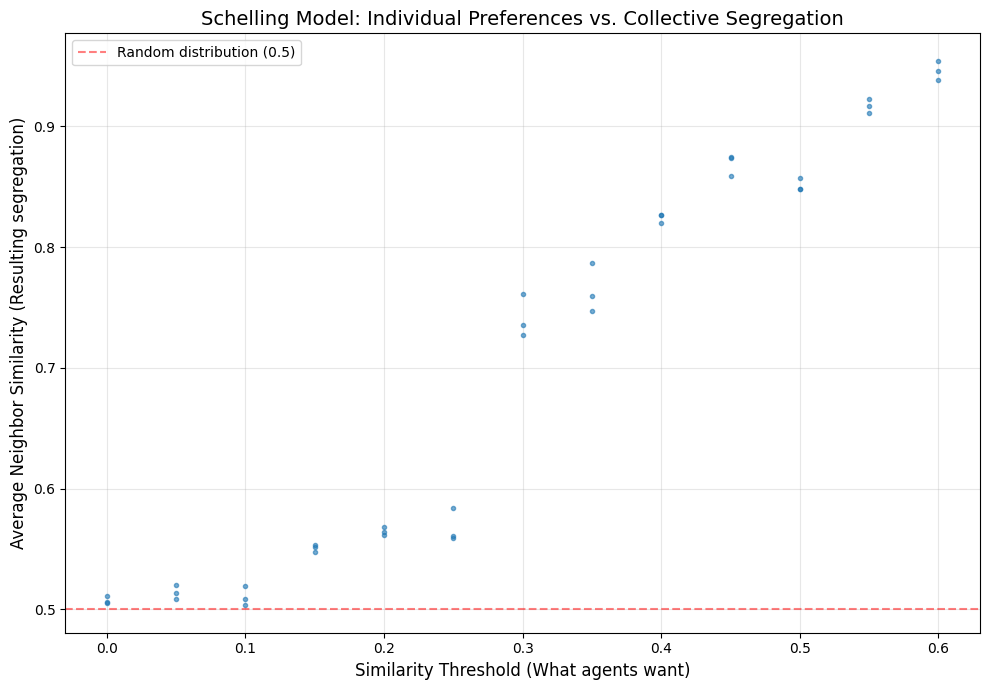

In [8]:
def treshold_analysis():
    """
    Analyze how the similarity threshold affects the resulting level of segregation.
    
    This function runs the Schelling model with different similarity thresholds
    and measures the resulting average neighbor similarity (segregation level).
    
    The key insight: even when agents only want a modest fraction of same-type
    neighbors (e.g., 30-40%), the model often produces much higher levels of
    segregation (e.g., 70-90%). This demonstrates how individual preferences
    can lead to collective segregation even without strong preferences.
    
    Parameters:
    -----------
    None (uses hardcoded parameters for consistency)
    
    Returns:
    --------
    thresholds : list
        List of similarity threshold values tested
    similarities : list
        List of resulting average neighbor similarity values
    """
    # Model parameters - these stay constant throughout the analysis
    size_grid = 50
    fraction_empty = 0.1
    fraction_A = 0.5  # Equal number of Type A and Type B agents
    agents_per_step = 500  # Check 500 agents per update step
    num_runs_per_threshold = 3  # Run multiple times for each threshold to get average
    
    # Define the range of thresholds to test
    # We'll test thresholds from 0.0 to 0.6 in steps of 0.05
    threshold_min = 0.0
    threshold_max = 0.6
    threshold_step = 0.05
    thresholds_to_test = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)
    
    # Lists to store results
    thresholds = []  # Will store each threshold value (repeated for each run)
    similarities = []  # Will store the resulting similarity for each run
    
    # Loop through each threshold value
    print(f"Running analysis for {len(thresholds_to_test)} threshold values...")
    for threshold in thresholds_to_test:
        # Round to avoid floating point precision issues
        threshold = round(threshold, 2)
        
        # Run the simulation multiple times for this threshold
        # This helps us see the variability and get a more robust average
        similarities_for_this_threshold = []
        
        for run in range(num_runs_per_threshold):
            # Initialize a fresh grid for each run
            # This ensures each run starts from a random configuration
            grid, emptycells = initialize_grid(size_grid, fraction_empty, fraction_A)
            
            # Run the simulation until convergence or max iterations
            max_iterations = 100
            for iteration in range(max_iterations):
                # Update the grid by checking and moving unsatisfied agents
                grid, emptycells, was_move = update(
                    grid, emptycells, size_grid, threshold, agents_per_step
                )
                
                # If no moves were made, the system has converged
                # (all agents are satisfied or no moves possible)
                if not was_move:
                    break
            
            # After the simulation has run, measure the resulting segregation
            # This tells us how segregated the final state is
            final_similarity = average_neighbor_similarity(grid)
            similarities_for_this_threshold.append(final_similarity)
            
            # Store the results
            thresholds.append(threshold)
            similarities.append(final_similarity)
        
        # Print progress (optional, but helpful for long runs)
        avg_similarity = np.mean(similarities_for_this_threshold)
        print(f"  Threshold {threshold:.2f}: Average similarity = {avg_similarity:.3f}")
    
    print("Analysis complete!")
    return thresholds, similarities

# Run the threshold analysis to see how similarity threshold affects segregation
# This will take a few minutes as it runs multiple simulations for each threshold value
thresholds, similarities = treshold_analysis()

# Create a figure to visualize the relationship between threshold and segregation
# The x-axis shows the similarity threshold (what agents want)
# The y-axis shows the resulting average neighbor similarity (what they actually get)
plt.figure(figsize=(10, 7))

# Plot the results as a scatter plot with dots
# Each dot represents one simulation run
# You'll see multiple dots at each threshold value because we run multiple simulations
plt.plot(thresholds, similarities, marker='.', linestyle='None', alpha=0.6)

# Add labels and title to make the plot clear
plt.xlabel('Similarity Threshold (What agents want)', fontsize=12)
plt.ylabel('Average Neighbor Similarity (Resulting segregation)', fontsize=12)
plt.title('Schelling Model: Individual Preferences vs. Collective Segregation', fontsize=14)
plt.grid(True, alpha=0.3)  # Add a light grid for easier reading

# Add a reference line at 0.5 (random distribution)
# This helps visualize when segregation exceeds random mixing
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random distribution (0.5)')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout so labels aren't cut off
plt.show()



We see that the resulting level of segregation is far higher on average than the threshold.

When the agents would prefer a 50/50 neighorhood, the result is 90% homogenous. 

We also see a rapid jump around threshold of 25%, where it reaches 70% homogeneity. 